In [1]:
import scipy.io
import pandas as pd
import os
import random

import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt

In [2]:
SUBJECTS_FOLDER = '/content/drive/MyDrive/Social memory cuing full dataset/derivatives/EEGPreprocessedDataTableStudy'
SUBJECTS = [ name for name in os.listdir(SUBJECTS_FOLDER) if os.path.isdir(os.path.join(SUBJECTS_FOLDER, name)) ]
SUBJECTS.sort()
print(SUBJECTS)
matrices_path = "/content/drive/MyDrive/Tesi/Classification+GL/HyperParamsTuning_GCN_GL_NewNorm/"

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-40', 'sub-41', 'sub-43', 'sub-44', 'sub-45', 'sub-46', 'sub-48', 'sub-49', 'sub-50']


In [3]:
soc_matrices, non_soc_matrices, diff_matrices, diff_sn_matrices, diff_ns_matrices = [], [], [], [], []

sweep_list = [8,"6*",3,5,8,0,1,4,1,6,3,10,"8*","6*",7,2,"/",4,"/","8*",9,9,7,9,\
              "5*",0,2,"/",0,"1*",1,9,3,11,"4*",8,9,0,4,1,3,7,5,19]



sweep_list = [str(x) for x in sweep_list]
folders = os.listdir(matrices_path)
folders.sort()

for i, fold in enumerate(folders):
  try:
    path_soc = matrices_path + fold + "/sweep0/" + sweep_list[i] + "/learned_soc.pt"
    path_non_soc = matrices_path + fold + "/sweep0/" + sweep_list[i] + "/learned_non_soc.pt"
    
    soc = torch.load(path_soc).cpu().detach().numpy()
    soc_matrices.append(soc)
    non_soc = torch.load(path_non_soc).cpu().detach().numpy()
    non_soc_matrices.append(non_soc)
    
    diff_matrices.append(np.abs(soc-non_soc))
    sn = soc-non_soc
    sn[sn < 0] = 0
    diff_sn_matrices.append(sn)
    ns = non_soc - soc
    ns[ns<0] = 0
    diff_ns_matrices.append(ns)
  except:
    pass

print(np.shape(soc_matrices))
print(np.shape(non_soc_matrices))
print(np.shape(diff_matrices))
print(np.shape(diff_sn_matrices))
print(np.shape(diff_ns_matrices))

(34, 29, 29)
(34, 29, 29)
(34, 29, 29)
(34, 29, 29)
(34, 29, 29)


In [4]:
#take best models (according to hyperparams optimization)
sweep_list = [8,"6*",3,5,8,0,1,4,1,6,3,9,"8*","6*",7,2,"/",4,"/","8*",9,9,7,9,\
              "5*",0,2,"/",0,"1*",1,9,3,11,"4*",8,9,0,4,1,3,7,5,19]

print(len(sweep_list))
valid_subs = []
for i, id in enumerate(sweep_list):
  try:
    temp = id + 1
    valid_subs.append(i)
  except:
    continue
print(len(valid_subs))

44
34


In [5]:
channels_list = ['Fp1','Fpz','Fp2',
    'AF3','AF4',
    'F7','F3','Fz','F4','F8',
    'FC5','FC1','FC2','FC6',
    'C3','Cz','C4',
    'CP5','CP1','CP2','CP6',
    'P5','P3','Pz','P4','P6',
    'POz','O1','O2']

num_channels = len(channels_list)
channels_occ = ['POz','O1','O2','P5','P3','Pz','P4','P6']
channels_occ_idxs = [channels_list.index(i) for i in channels_occ]
print(channels_occ_idxs)
channels_front = ['F7','F3','Fz','F4','F8','FC5','FC1','FC2','FC6']
channels_front_idxs = [channels_list.index(i) for i in channels_front]
print(channels_front_idxs)
channels_left = ['Fp1','AF3','F7','F3','FC5','FC1','C3','CP5','CP1','P5','P3','O1']
channels_left_idxs = [channels_list.index(i) for i in channels_left]
print(channels_left_idxs)
channels_right = ['Fp2', 'AF4', 'F4','F8', 'FC2','FC6', 'C4', 'CP2','CP6', 'P4','P6', 'O2']
channels_right_idxs = [channels_list.index(i) for i in channels_right]
print(channels_right_idxs)

max_arrows_occ_front = 2*len(channels_occ)*len(channels_front)
max_arrows_left_right = 2*len(channels_left)*len(channels_right)

max_arrows_occ_occ = len(channels_occ)*len(channels_occ)
max_arrows_front_front = len(channels_front)*len(channels_front)
max_arrows_left_left = len(channels_left)*len(channels_left)
max_arrows_right_right = len(channels_right)*len(channels_right)

[26, 27, 28, 21, 22, 23, 24, 25]
[5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 3, 5, 6, 10, 11, 14, 17, 18, 21, 22, 27]
[2, 4, 8, 9, 12, 13, 16, 19, 20, 24, 25, 28]


# Indici di peso intra

## Social

In [6]:
w_occ_soc, w_front_soc, w_right_soc, w_left_soc = [], [], [], []

for i, mat in enumerate(soc_matrices):
  w_occ_soc.append(np.sum(mat[channels_occ_idxs, channels_occ_idxs]))
  w_front_soc.append(np.sum(mat[channels_front_idxs, channels_front_idxs]))
  w_left_soc.append(np.sum(mat[channels_left_idxs, channels_left_idxs]))
  w_right_soc.append(np.sum(mat[channels_right_idxs, channels_right_idxs]))
  
print(w_occ_soc)
print(w_front_soc)
print(w_right_soc)
print(w_left_soc)

[0.0019300455667877131, 0.004237325527458835, 0.008214897028719446, 0.0071712219842487695, 0.004539400462778098, 0.003454513407315103, 0.0012842003149480582, 0.0023532888634785706, 0.0016343771158491033, 0.001221372194584199, 0.005244666345641078, 0.0015479654258710247, 0.008214865081666953, 0.0028203742387571448, 0.009512184307031667, 0.009495175858516603, 0.008147574216442622, 0.00455633583308521, 0.0004130809292082578, 0.001907501764332146, 0.009511591358909346, 0.009395291716574525, 0.0028580497658524614, 0.008124349782000401, 0.0009058529021460408, 0.0033530261592848885, 0.008857518586448824, 0.0002651076465198702, 0.00947322706087596, 0.0009708939489892781, 0.004561231785419463, 0.003069685307060405, 0.005202753396087079, 0.0014327571471113728]
[0.002171301262636177, 0.00476699121839119, 0.009241759157309376, 0.008067624732279864, 0.00510682552062536, 0.003886327583229491, 0.0014447253543165655, 0.002647449971413392, 0.0018386742553302413, 0.001374043718907224, 0.0059002496388462

## Non Social

In [7]:
w_occ_nonsoc, w_front_nonsoc, w_right_nonsoc, w_left_nonsoc = [], [], [], []

for i, mat in enumerate(non_soc_matrices):
  w_occ_nonsoc.append(np.sum(mat[channels_occ_idxs, channels_occ_idxs]))
  w_front_nonsoc.append(np.sum(mat[channels_front_idxs, channels_front_idxs]))
  w_left_nonsoc.append(np.sum(mat[channels_left_idxs, channels_left_idxs]))
  w_right_nonsoc.append(np.sum(mat[channels_right_idxs, channels_right_idxs]))
  
print(w_occ_nonsoc)
print(w_front_nonsoc)
print(w_right_nonsoc)
print(w_left_nonsoc)

[0.0023604702783743166, 0.004013434152790457, 0.008227453854672752, 0.007063354905741996, 0.0036558533980247214, 0.002939431611995086, 0.0017132937862218676, 0.002572253804109155, 0.0012012578635897638, 0.0017504009542422122, 0.005542824531916582, 0.0020349780240976594, 0.008341952966669727, 0.0025364386195312174, 0.00951235821350075, 0.009483945192662335, 0.008074013470428808, 0.0044510655973581115, 0.0011859385642533486, 0.002224363607289257, 0.00951190643961182, 0.00937919371950812, 0.003611927295302053, 0.00823209797021262, 0.0011204101115126189, 0.002286292531748683, 0.008664061408388967, 0.001003687362128688, 0.00947917119691093, 0.0009702551397179392, 0.0037472431155754996, 0.003439679510770684, 0.0045724603892888845, 0.002416503112217777]
[0.002655529063171106, 0.004515113421889264, 0.009255885586506843, 0.007946274268959747, 0.004112835072777812, 0.0033068605634944716, 0.0019274555094996012, 0.0028937855296227995, 0.0013514150965384841, 0.0019692010735224883, 0.006235677598406

## Diff

In [8]:
w_occ_diff, w_front_diff, w_right_diff, w_left_diff = [], [], [], []

for i, mat in enumerate(diff_matrices):
  w_occ_diff.append(np.sum(mat[channels_occ_idxs, channels_occ_idxs]))
  w_front_diff.append(np.sum(mat[channels_front_idxs, channels_front_idxs]))
  w_left_diff.append(np.sum(mat[channels_left_idxs, channels_left_idxs]))
  w_right_diff.append(np.sum(mat[channels_right_idxs, channels_right_idxs]))
  
print(w_occ_diff)
print(w_front_diff)
print(w_right_diff)
print(w_left_diff)

[0.00043042471158660344, 0.00022389137466837818, 1.2556825953304604e-05, 0.00010786707850677247, 0.000883547064753376, 0.000515081795320017, 0.00042909347127380944, 0.00021896494063058453, 0.00043311925225933954, 0.0005290287596580129, 0.0002981581862755043, 0.00048701259822663467, 0.00012708788500277084, 0.00028393561922592707, 1.7390646908275152e-07, 1.1230665854265482e-05, 7.35607460138133e-05, 0.00010527023572709786, 0.000772857635045091, 0.0003168618429571111, 3.150807024734307e-07, 1.609799706640499e-05, 0.0007538775294495917, 0.0001077481882122179, 0.00021455720936657807, 0.0010667336275362056, 0.0001934571780598561, 0.0007385797156088177, 5.944136034970529e-06, 6.388092713389097e-07, 0.0008139886698439627, 0.00036999420371027923, 0.0006302930067981945, 0.0009837459651064044]
[0.00048422780053492887, 0.0002518777965019256, 1.4126429197467436e-05, 0.00012135046332011903, 0.000993990447847548, 0.0005794670197350191, 0.0004827301551830356, 0.00024633555820940766, 0.0004872591587917

In [9]:
w_occ_diff_sn, w_front_diff_sn, w_right_diff_sn, w_left_diff_sn = [], [], [], []

for i, mat in enumerate(diff_sn_matrices):
  w_occ_diff_sn.append(np.sum(mat[channels_occ_idxs, channels_occ_idxs]))
  w_front_diff_sn.append(np.sum(mat[channels_front_idxs, channels_front_idxs]))
  w_left_diff_sn.append(np.sum(mat[channels_left_idxs, channels_left_idxs]))
  w_right_diff_sn.append(np.sum(mat[channels_right_idxs, channels_right_idxs]))
  
print(w_occ_diff_sn)
print(w_front_diff_sn)
print(w_right_diff_sn)
print(w_left_diff_sn)

[0.0, 0.00022389137466837818, 0.0, 0.00010786707850677247, 0.000883547064753376, 0.000515081795320017, 0.0, 0.0, 0.00043311925225933954, 0.0, 0.0, 0.0, 0.0, 0.00028393561922592707, 0.0, 1.1230665854265482e-05, 7.35607460138133e-05, 0.00010527023572709786, 0.0, 0.0, 0.0, 1.609799706640499e-05, 0.0, 0.0, 0.0, 0.0010667336275362056, 0.0001934571780598561, 0.0, 0.0, 6.388092713389097e-07, 0.0008139886698439627, 0.0, 0.0006302930067981945, 0.0]
[0.0, 0.0002518777965019256, 0.0, 0.00012135046332011903, 0.000993990447847548, 0.0005794670197350191, 0.0, 0.0, 0.00048725915879175696, 0.0, 0.0, 0.0, 0.0, 0.00031942757162916783, 0.0, 1.263449908604818e-05, 8.27558392655402e-05, 0.00011842901519298497, 0.0, 0.0, 0.0, 1.811024669970537e-05, 0.0, 0.0, 0.0, 0.0012000753309782313, 0.0002176393253173381, 0.0, 0.0, 7.186604302562887e-07, 0.0009157372535744581, 0.0, 0.0007090796326479688, 0.0]
[0.0, 0.0003358370620025673, 0.0, 0.0001618006177601587, 0.0013253205971300642, 0.0007726226929800255, 0.0, 0.0, 

In [10]:
w_occ_diff_ns, w_front_diff_ns, w_right_diff_ns, w_left_diff_ns = [], [], [], []

for i, mat in enumerate(diff_ns_matrices):
  w_occ_diff_ns.append(np.sum(mat[channels_occ_idxs, channels_occ_idxs]))
  w_front_diff_ns.append(np.sum(mat[channels_front_idxs, channels_front_idxs]))
  w_left_diff_ns.append(np.sum(mat[channels_left_idxs, channels_left_idxs]))
  w_right_diff_ns.append(np.sum(mat[channels_right_idxs, channels_right_idxs]))
  
print(w_occ_diff_ns)
print(w_front_diff_ns)
print(w_right_diff_ns)
print(w_left_diff_ns)

[0.00043042471158660344, 0.0, 1.2556825953304604e-05, 0.0, 0.0, 0.0, 0.00042909347127380944, 0.00021896494063058453, 0.0, 0.0005290287596580129, 0.0002981581862755043, 0.00048701259822663467, 0.00012708788500277084, 0.0, 1.7390646908275152e-07, 0.0, 0.0, 0.0, 0.000772857635045091, 0.0003168618429571111, 3.150807024734307e-07, 0.0, 0.0007538775294495917, 0.0001077481882122179, 0.00021455720936657807, 0.0, 0.0, 0.0007385797156088177, 5.944136034970529e-06, 0.0, 0.0, 0.00036999420371027923, 0.0, 0.0009837459651064044]
[0.00048422780053492887, 0.0, 1.4126429197467436e-05, 0.0, 0.0, 0.0, 0.0004827301551830356, 0.00024633555820940766, 0.0, 0.0005951573546152645, 0.00033542795955994237, 0.0005478891730049641, 0.0001429738706281167, 0.0, 1.956447777183394e-07, 0.0, 0.0, 0.0, 0.0008694648394257274, 0.00035646957332675, 3.544657902823656e-07, 0.0, 0.0008481122206307908, 0.00012121671173874514, 0.00024137686053740036, 0.0, 0.0, 0.00083090218005992, 6.687153039341845e-06, 0.0, 0.0, 0.0004162434791

In [11]:
from scipy import stats

print("Intra connections occ: " + str(stats.ttest_rel(w_occ_soc, w_occ_nonsoc)))
print("Intra connections front: " + str(stats.ttest_rel(w_front_soc, w_front_nonsoc)))
print("Intra connections left: " + str(stats.ttest_rel(w_left_soc, w_left_nonsoc)))
print("Intra connections right: " + str(stats.ttest_rel(w_right_soc, w_right_nonsoc)))

Intra connections occ: Ttest_relResult(statistic=-0.5146417849678468, pvalue=0.6102332622447515)
Intra connections front: Ttest_relResult(statistic=-0.514641784967848, pvalue=0.6102332622447506)
Intra connections left: Ttest_relResult(statistic=-0.5146417849678495, pvalue=0.6102332622447495)
Intra connections right: Ttest_relResult(statistic=-0.51464178496785, pvalue=0.6102332622447494)


# Indici di peso inter 

## Social

In [12]:
w_occ_front_soc, w_legt_right_soc= [], []

for i, mat in enumerate(soc_matrices):
  w_occ_front_soc.append(np.sum(mat[channels_occ_idxs, :][:, channels_front_idxs]))
  w_legt_right_soc.append(np.sum(mat[channels_left_idxs, :][:, channels_right_idxs]))

  
print(w_occ_front_soc)
print(w_legt_right_soc)

[0.018421429337737365, 0.04361654435222835, 0.07781524380000868, 0.07918674606748645, 0.0431310070550746, 0.04910179145749047, 0.0223704526409662, 0.02505048664970291, 0.02251266367578162, 0.015013692700183849, 0.06367324130966535, 0.024013909400639494, 0.08413124889352577, 0.07658275747329045, 0.085609658763285, 0.08547835704768551, 0.08996413751996542, 0.04754275317524034, 0.00402138058672498, 0.018392406125708506, 0.08560432223018412, 0.08565573772416021, 0.029139692784384566, 0.07526112356740439, 0.008180527191926789, 0.034198645670899225, 0.0855396530151842, 0.006257059398929572, 0.08557368160411122, 0.008752781476380247, 0.046091970025321186, 0.02992972103084051, 0.05537058634139815, 0.013754603670611761]
[0.1693945107720229, 0.2547673337898667, 0.19063960120767476, 0.19701489805726918, 0.18924806155713986, 0.1686710220179549, 0.4320959608500613, 0.10977344186644387, 0.2857081589403559, 0.4153673608084971, 0.1969102364616176, 0.31969205313130805, 0.184060644030807, 0.292468538567

##Diff

In [13]:
w_occ_front_diff, w_legt_right_diff= [], []

for i, mat in enumerate(diff_matrices):
  w_occ_front_diff.append(np.sum(mat[channels_occ_idxs, :][:, channels_front_idxs]))
  w_legt_right_diff.append(np.sum(mat[channels_left_idxs, :][:, channels_right_idxs]))

  
print(w_occ_front_diff)
print(w_legt_right_diff)

[0.004138015565129059, 0.0035297774399128223, 0.001540594026938216, 0.006390472537372595, 0.009311253318792855, 0.007150427180779851, 0.009484617609119598, 0.005042186354839422, 0.012742471784717711, 0.006102320151407659, 0.006869659396094853, 0.009854068342710885, 0.0023025983588794274, 0.01132671905443549, 1.5651582217467153e-06, 0.0001247829575396586, 0.005761680188522054, 0.005320531337063616, 0.008508419242921669, 0.002970777759944822, 2.8357263222589246e-06, 0.0005352605717284058, 0.0074329995229863634, 0.00146725390588633, 0.0022596570946641146, 0.010417471450555896, 0.002664097303359524, 0.007413300226728717, 0.0002456740143802103, 3.638101187232103e-05, 0.008744182108595842, 0.008213999375587023, 0.01021582929659323, 0.012728372711220817]
[0.05209285923111619, 0.04122752780752083, 0.005230081213117991, 0.020157930679989982, 0.055133187354884136, 0.05672635817415815, 0.14568179177930562, 0.031274344970171855, 0.1386041912247534, 0.10892570070654321, 0.027101711681172758, 0.0845

In [14]:
w_occ_front_diff_sn, w_legt_right_diff_sn= [], []

for i, mat in enumerate(diff_sn_matrices):
  w_occ_front_diff_sn.append(np.sum(mat[channels_occ_idxs, :][:, channels_front_idxs]))
  w_legt_right_diff_sn.append(np.sum(mat[channels_left_idxs, :][:, channels_right_idxs]))

  
print(w_occ_front_diff_sn)
print(w_legt_right_diff_sn)

[0.00015404054406312418, 0.0017572240180238952, 0.0008050860504106618, 0.004641479021861515, 0.00915166841697389, 0.006969352410632951, 0.005629156820272604, 0.0020232519103283828, 0.009170546275262571, 0.0016339987657164495, 0.004424251271875449, 0.006286562449267568, 0.0011432023725345094, 0.008932732009373327, 0.0, 0.00011863881402913654, 0.0018608897505266913, 0.0009780451314327385, 0.0, 0.0005476455720422812, 0.0, 0.0004427389474920534, 0.00015262600944350967, 0.0008362516665758391, 0.0, 0.008720834515455599, 0.0010918442559808, 0.001857698097247912, 9.97983195647114e-05, 1.7862552913016708e-05, 0.008728714066090059, 0.0010213575503710613, 0.006383841114930714, 0.0]
[0.03483116316694915, 0.02020908100921659, 0.003687888674711653, 0.005581952678134543, 0.03312286232859426, 0.01920711396537672, 0.07881206570951012, 0.01583780411507084, 0.06621558771670953, 0.0705850768030829, 0.015005141351494826, 0.04723566581080686, 0.0048095641800763676, 0.0096748897640594, 4.550167725931318e-06,

In [15]:
w_occ_front_diff_ns, w_legt_right_diff_ns= [], []

for i, mat in enumerate(diff_ns_matrices):
  w_occ_front_diff_ns.append(np.sum(mat[channels_occ_idxs, :][:, channels_front_idxs]))
  w_legt_right_diff_ns.append(np.sum(mat[channels_left_idxs, :][:, channels_right_idxs]))

  
print(w_occ_front_diff_ns)
print(w_legt_right_diff_ns)

[0.003983975021065935, 0.001772553421888927, 0.0007355079765275542, 0.0017489935155110793, 0.00015958490181896612, 0.00018107477014690023, 0.0038554607888469936, 0.0030189344445110395, 0.003571925509455139, 0.004468321385691209, 0.002445408124219404, 0.003567505893443317, 0.0011593959863449182, 0.00239398704506216, 1.5651582217467153e-06, 6.14414351052207e-06, 0.0039007904379953634, 0.004342486205630878, 0.008508419242921669, 0.0024231321879025405, 2.8357263222589246e-06, 9.252162423635242e-05, 0.007280373513542854, 0.000631002239310491, 0.0022596570946641146, 0.001696636935100297, 0.0015722530473787242, 0.005555602129480804, 0.00014587569481549893, 1.851845895930432e-05, 1.5468042505782133e-05, 0.007192641825215961, 0.0038319881816625168, 0.012728372711220817]
[0.017261696064167033, 0.02101844679830424, 0.0015421925384063383, 0.01457597800185544, 0.022010325026289877, 0.037519244208781444, 0.0668697260697955, 0.015436540855101016, 0.0723886035080439, 0.03834062390346031, 0.01209657032

## Non social

In [18]:
w_occ_front_nonsoc, w_legt_right_nonsoc= [], []

for i, mat in enumerate(non_soc_matrices):
  w_occ_front_nonsoc.append(np.sum(mat[channels_occ_idxs, :][:, channels_front_idxs]))
  w_legt_right_nonsoc.append(np.sum(mat[channels_left_idxs, :][:, channels_right_idxs]))

  
print(w_occ_front_nonsoc)
print(w_legt_right_nonsoc)

[0.02225136381474018, 0.04363187375609339, 0.07774566572612555, 0.076294260561136, 0.034138923539919666, 0.04231351381700442, 0.020596756609540585, 0.02604616918388556, 0.016914042909974187, 0.017848015320158606, 0.06169439816200931, 0.021294852844815245, 0.08414744250733619, 0.07004401250897926, 0.08561122392150673, 0.0853658623771669, 0.0920040382074341, 0.05090719424943848, 0.012529799829646648, 0.020267892741568767, 0.08560715795650638, 0.08530552040090453, 0.03626744028848391, 0.07505587414013903, 0.010440184286590905, 0.027174448090543916, 0.08602006180658212, 0.009954963431162464, 0.085619758979362, 0.008753437382426534, 0.037378724001736904, 0.03610100530568541, 0.05281873340812996, 0.026482976381832578]
[0.1518250436692408, 0.25557669957895435, 0.18849390507136946, 0.20600892338099008, 0.17813552425483548, 0.1869831522613596, 0.4201536212103467, 0.10937217860647408, 0.2918811747316903, 0.38312290790887454, 0.19400166543980069, 0.3097305826920025, 0.1821693041727356, 0.31134761

In [19]:
print("Occ-Front inter connections: " + str(stats.ttest_rel(w_occ_front_soc, w_occ_front_nonsoc)))
print("Left-right inter connections: " + str(stats.ttest_rel(w_legt_right_soc, w_legt_right_nonsoc)))

Occ-Front inter connections: Ttest_relResult(statistic=0.011308635228212894, pvalue=0.9910452985016469)
Left-right inter connections: Ttest_relResult(statistic=1.6988379072351696, pvalue=0.09876026536134208)


# Modularity

In [20]:
import networkx as nx
import networkx.algorithms.community as nx_comm

def modularity(G, communities, weight="weight", resolution=1):

    if not isinstance(communities, list):
        communities = list(communities)

    directed = False
    
    out_degree = in_degree = dict(G.degree(weight=weight))
    deg_sum = sum(out_degree.values())
    m = deg_sum / 2
    norm = 1 / deg_sum**2

    def community_contribution(community):
        comm = set(community)
        L_c = sum(wt for u, v, wt in G.edges(comm, data=weight, default=1) if v in comm)

        out_degree_sum = sum(out_degree[u] for u in comm)
        in_degree_sum = sum(in_degree[u] for u in comm) if directed else out_degree_sum

        return L_c / m - resolution * out_degree_sum * in_degree_sum * norm

    return sum(map(community_contribution, communities))

## Social

In [21]:
mod_occ_front_soc, mod_left_right_soc= [], []

for i, mat in enumerate(soc_matrices):
  mod_occ_front_soc.append(modularity(nx.from_numpy_array(mat), [channels_occ_idxs, channels_front_idxs]))
  mod_left_right_soc.append(modularity(nx.from_numpy_array(mat), [channels_left_idxs,channels_right_idxs]))

print(mod_occ_front_soc)
print(mod_left_right_soc)

[-0.0014738158807557737, 0.034548075386039545, 0.023852895025478812, 0.02067118607954159, 0.030514909480264186, 0.011887483265969792, 0.03925113016453804, 0.04514713357033388, 0.11992668071293575, 0.10177501841990622, 0.03340159006393022, 0.07395801528885391, 0.011687296388704957, -0.009526132498012277, 0.013801669836204275, 0.013920545146453647, 0.011391108454967422, 0.06435403995511267, -0.07638865218366772, -0.003612395454092053, 0.013787563795945326, 0.013987864120937, -0.04865656614847702, 0.017932682482001305, -0.03277815057837886, 0.0377820394534665, 0.01190685433757685, 0.00425961113251858, 0.013851226827593432, -0.17155729066405007, 0.05945650112775389, 0.06919138845391214, 0.03450852846284855, 0.005819395877518613]
[0.015180162531106711, -0.13081923044334637, -0.017219307633037917, -0.029336031312803962, -0.040236305584913715, -0.022108634701704655, -0.3897652291409959, 0.0352684814281648, -0.18071621780000793, -0.37903538945925624, -0.02815620431290647, -0.2312035310854711, 

##Diff

In [22]:
mod_occ_front_diff, mod_left_right_diff= [], []

for i, mat in enumerate(diff_matrices):
  mod_occ_front_diff.append(modularity(nx.from_numpy_array(mat), [channels_occ_idxs, channels_front_idxs]))
  mod_left_right_diff.append(modularity(nx.from_numpy_array(mat), [channels_left_idxs,channels_right_idxs]))

print(mod_occ_front_diff)
print(mod_left_right_diff)

[-0.0042728761086347645, 0.0019128459428224796, -0.023958799113568824, 0.029945698623949163, 0.002637431266165984, -0.010942205788008634, 0.010817606622099997, 0.03604456607420927, 0.087330630268486, 0.06981617468483933, 0.0192726399585011, 0.04672629070222394, 0.01169705317691895, -0.0240677364192314, 0.12631295232642292, 0.012371756742399355, -0.026891926613822878, 0.04378879075316757, -0.01617562315613798, 0.026672125376713568, -0.04310055258384651, 0.025348041930118095, -0.04033452036461459, 0.014620581891250942, -0.056407446535104294, 0.0012423532894125372, -0.014966319381838455, 0.010986544850184682, 0.020588943661797546, -0.17348560115228395, 0.05891462444007098, 0.04517011021616942, 0.014696290583535963, -0.02654617061743817]
[-0.006200042041880238, -0.19681127383101565, -0.1463680532341571, -0.13301093018212562, -0.0558763040384222, -0.08815330374550873, -0.37184891377382645, 0.016970159119375675, -0.1746686643368192, -0.32668177072063265, -0.05488533788741698, -0.187752561196

In [23]:
mod_occ_front_diff_sn, mod_left_right_diff_sn= [], []

for i, mat in enumerate(diff_sn_matrices):
  mod_occ_front_diff_sn.append(modularity(nx.from_numpy_array(mat), [channels_occ_idxs, channels_front_idxs]))
  mod_left_right_diff_sn.append(modularity(nx.from_numpy_array(mat), [channels_left_idxs,channels_right_idxs]))

print(mod_occ_front_diff_sn)
print(mod_left_right_diff_sn)

[-0.04912730649713608, 0.03044053455407866, -0.07019995861615086, -0.05384521857258979, 0.03433055955923409, 0.01240532836393863, -0.0638804018367634, 0.0453510572124153, 0.14901942743128507, 0.019001734198838986, -0.02982125022033392, -0.00975014342140414, -0.030614488353757192, -0.08418518471352598, 0.10591685124140215, -0.010636354164577741, 0.030045957810366092, 0.09787852642521905, -0.03685121794317512, -0.0327026585561221, -0.1315368619322572, -0.10831407330855763, -0.1654400113903174, -0.011042146330134298, -0.14930368580893613, 0.041127089325107516, 0.002001057971666699, -0.0339418481288603, 0.04964689668827264, -0.1682308505657837, -0.01702313617701296, -0.057665224543775595, 0.02670298598562519, -0.06437388084004693]
[-0.10061454125196125, -0.1677078159343704, -0.3180171984427865, 0.057647686272034815, -0.11655585942178953, -0.0637801628869114, -0.43673857331372196, -0.07567838371890312, -0.1568798074556566, -0.48306394816480236, -0.07962717025326399, -0.22280552847682938, -0

In [24]:
mod_occ_front_diff_ns, mod_left_right_diff_ns= [], []

for i, mat in enumerate(diff_ns_matrices):
  mod_occ_front_diff_ns.append(modularity(nx.from_numpy_array(mat), [channels_occ_idxs, channels_front_idxs]))
  mod_left_right_diff_ns.append(modularity(nx.from_numpy_array(mat), [channels_left_idxs,channels_right_idxs]))

print(mod_occ_front_diff_ns)
print(mod_left_right_diff_ns)

[0.025848017739256428, -0.03157164702524984, 0.015927312459894552, 0.10244258218213759, -0.0711874690553063, -0.060050883348873846, 0.06101764230250442, -0.009027880827487652, 0.011925897711595607, 0.09874192494884199, 0.05915940887452246, 0.10219725820393426, 0.008288608616061729, 0.03656498121573118, 0.0895969651815953, -0.06178034138968304, -0.08721766812157804, -0.013654711413359565, -0.06053332457154731, 0.07203597710962455, 0.03222217344615744, 0.16007620207815798, 0.03794036202038837, 0.038901412514981304, 0.020662687503834085, -0.04772642680713879, -0.04077396030998616, 0.04998330569030672, -0.015379013958124021, -0.17895898608370847, 0.133282259823015, 0.07380552667188993, -0.017464371323985435, -0.021026748925760633]
[0.079646259963607, -0.22976144813973698, 0.019741383576466265, -0.33456495032788347, 0.002976062079621228, -0.15892665479071405, -0.30790425227618234, 0.10429032344096825, -0.19277610751435587, -0.17871900433998794, -0.035742151552004664, -0.16133241941761728, -

## Non social

In [25]:
mod_occ_front_nonsoc, mod_left_right_nonsoc= [], []

for i, mat in enumerate(non_soc_matrices):
  mod_occ_front_nonsoc.append(modularity(nx.from_numpy_array(mat), [channels_occ_idxs, channels_front_idxs]))
  mod_left_right_nonsoc.append(modularity(nx.from_numpy_array(mat), [channels_left_idxs,channels_right_idxs]))

print(mod_occ_front_nonsoc)
print(mod_left_right_nonsoc)

[0.008856477702947264, 0.031139249531089274, 0.024945567513670858, 0.027321375083191338, 0.017832160839170125, 0.00576703617428358, 0.06454498450128746, 0.03305952389794624, 0.08598952077384026, 0.11272234814785352, 0.03830648382750706, 0.09081703918352249, 0.01220334906990396, -0.0010129806412755987, 0.013797664001353613, 0.014061072013728623, 0.009026614145115311, 0.05633617820425635, -0.07168075800179362, 0.010902024350790518, 0.013798030342446019, 0.014757675832865969, -0.012664726263101674, 0.01882884890524654, -0.011794604321938696, 0.024887179830805614, 0.011132275484311699, 0.024966793572850175, 0.013739341024080531, -0.17340927142367601, 0.07409038330530504, 0.09300917227279516, 0.029954570888462415, 0.02312196833560619]
[0.04305146163598325, -0.13527259925267965, -0.013853792664284298, -0.044588694989022015, -0.024702580355000725, -0.03423238571163709, -0.367653546694834, 0.060435093775651594, -0.19018043418956745, -0.3343308672386201, -0.025254962088754385, -0.22164896490132

In [26]:
print("Occ-Front modularity: " + str(stats.ttest_rel(mod_occ_front_soc, mod_occ_front_nonsoc)))
print("Left-right modularity: " + str(stats.ttest_rel(mod_left_right_soc, mod_left_right_nonsoc)))

Occ-Front modularity: Ttest_relResult(statistic=-1.7967160506668463, pvalue=0.08153955707941196)
Left-right modularity: Ttest_relResult(statistic=-1.5710610035252954, pvalue=0.12570854761924016)


# Divisibilità

## Social

In [27]:
div_occ_front_soc, div_legt_right_soc= [], []


for i, mat in enumerate(soc_matrices):
  temp = 2*np.sum(mat[channels_occ_idxs, :][:, channels_front_idxs])
  div_occ_front_soc.append(841/(841 + temp))
  temp = np.sum(mat[channels_left_idxs, :][:, channels_right_idxs])
  div_legt_right_soc.append(841/(841 + temp))

  
print(div_occ_front_soc)
print(div_legt_right_soc)

[0.999956193525898, 0.9998962853253828, 0.9998149801511644, 0.9998117197698723, 0.999897439753797, 0.9998832436182878, 0.9999468031804898, 0.9999404304532614, 0.9999464650214962, 0.9999642968925929, 0.9998486002349681, 0.999942895272074, 0.9997999657080648, 0.9998179100772296, 0.9997964512888761, 0.9997967634132743, 0.9997861001326922, 0.9998869503484338, 0.9999904367606913, 0.9999562625405741, 0.9997964639746333, 0.9997963417521363, 0.9999307070782166, 0.9998210519483092, 0.9999805460926309, 0.999918678086631, 0.9997966177032959, 0.9999851201752794, 0.9997965368121046, 0.9999791852573376, 0.9998903997185912, 0.9999288285591214, 0.9998683393669086, 0.999967290954172]
[0.9997986202162401, 0.999697157931601, 0.9997733693264846, 0.9997657922049554, 0.9997750232043583, 0.9997994801425343, 0.9994864755422045, 0.9998694897558766, 0.9996603910465024, 0.9995063468330613, 0.9997659165956682, 0.9996200112084014, 0.9997811886213228, 0.9996523580686798, 0.9997964439996836, 0.9997964749299635, 0.99

##Diff

In [28]:
div_occ_front_diff, div_legt_right_diff= [], []

for i, mat in enumerate(diff_matrices):
  temp = 2*np.sum(mat[channels_occ_idxs, :][:, channels_front_idxs])
  div_occ_front_diff.append(max_arrows_occ_front/(max_arrows_occ_front + temp))
  temp = np.sum(mat[channels_left_idxs, :][:, channels_right_idxs])
  div_legt_right_diff.append(max_arrows_left_right/(max_arrows_left_right + temp))

  
print(div_occ_front_diff)
print(div_legt_right_diff)

[0.9999425308644867, 0.9999509777166367, 0.9999786033185648, 0.9999112513140093, 0.999870693759505, 0.9999006983731705, 0.9998682865505915, 0.9999299745378692, 0.9998230525411567, 0.99991525273616, 0.9999045971665123, 0.999863156668345, 0.9999680204899596, 0.9998427092018645, 0.9999999782616917, 0.9999982669063711, 0.9999199830672701, 0.9999261091916847, 0.9998818414736023, 0.9999587409001621, 0.9999999606149138, 0.9999925658806593, 0.9998967745521071, 0.9999796218888052, 0.9999686168586176, 0.9998553338278495, 0.9999630000176137, 0.9998970480970366, 0.9999965878725541, 0.9999994947084239, 0.9998785677738459, 0.9998859296888595, 0.9998581336109197, 0.9998232482923665]
[0.999819154727487, 0.9998568693510947, 0.9999818403255675, 0.9999300120837902, 0.9998086019619062, 0.9998030722667326, 0.9994944161895004, 0.9998914203152373, 0.9995189669512913, 0.9996219287533643, 0.9999059056890129, 0.9997066490620303, 0.9999731681210033, 0.999867278536835, 0.9999999696984496, 0.9999981629288073, 0.99

In [29]:
div_occ_front_diff_sn, div_legt_right_diff_sn= [], []

for i, mat in enumerate(diff_sn_matrices):
  temp = 2*np.sum(mat[channels_occ_idxs, :][:, channels_front_idxs])
  div_occ_front_diff_sn.append(max_arrows_occ_front/(max_arrows_occ_front + temp))
  temp = np.sum(mat[channels_left_idxs, :][:, channels_right_idxs])
  div_legt_right_diff_sn.append(max_arrows_left_right/(max_arrows_left_right + temp))

  
print(div_occ_front_diff_sn)
print(div_legt_right_diff_sn)

[0.9999978605525764, 0.9999755947064937, 0.9999888183743301, 0.9999355391690519, 0.9998729096482192, 0.9999032128074086, 0.999921823378447, 0.9999719000686516, 0.9998726475224519, 0.9999773060877238, 0.9999385558412851, 0.9999126942556077, 0.9999841224413712, 0.9998759496680417, 1.0, 0.9999983522414091, 0.9999741549770028, 0.9999864162243627, 1.0, 0.9999923938693531, 1.0, 0.9999938508857632, 0.999997880198807, 0.9999883855284174, 1.0, 0.9998788919673285, 0.9999848357264034, 0.9999741993032313, 0.9999986139141495, 0.9999997519090489, 0.9998787825556433, 0.9999858146796933, 0.9999113434007599, 1.0]
[0.999879073086313, 0.9999298345033715, 0.9999871949949608, 0.9999806185955137, 0.9998850032871239, 0.9999333130795066, 0.9997264218595447, 0.9999450106485955, 0.999770137613737, 0.9997549729807219, 0.9999479015291439, 0.999836014167254, 0.999983300403256, 0.99996640776124, 0.9999999842008068, 0.9999993085040978, 0.9999889212127233, 0.9999631708903667, 0.9997576624212692, 0.9999410028211256, 0

In [30]:
div_occ_front_diff_ns, div_legt_right_diff_ns= [], []

for i, mat in enumerate(diff_ns_matrices):
  temp = 2*np.sum(mat[channels_occ_idxs, :][:, channels_front_idxs])
  div_occ_front_diff_ns.append(max_arrows_occ_front/(max_arrows_occ_front + temp))
  temp = np.sum(mat[channels_left_idxs, :][:, channels_right_idxs])
  div_legt_right_diff_ns.append(max_arrows_left_right/(max_arrows_left_right + temp))

  
print(div_occ_front_diff_ns)
print(div_legt_right_diff_ns)

[0.9999446700751662, 0.9999753818085441, 0.9999897847157901, 0.9999757090134621, 0.9999977835479429, 0.9999974850789618, 0.9999464548007302, 0.9999580721129587, 0.9999503923845173, 0.9999379438319613, 0.999966037151789, 0.9999504537619869, 0.9999838975372608, 0.9999667512854434, 0.9999999782616917, 0.9999999146646807, 0.999945825290086, 0.9999396913289437, 0.9998818414736023, 0.9999663465188741, 0.9999999606149138, 0.9999987149790924, 0.999898893924673, 0.9999912361568151, 0.9999686168586176, 0.9999764361533916, 0.9999781636289572, 0.9999228448126951, 0.999997973952788, 0.9999997427992473, 0.9999997851661224, 0.9999001121754463, 0.9999467807743582, 0.9998232482923665]
[0.9999400671474948, 0.999927024607747, 0.9999946451934713, 0.9999493915266185, 0.9999235811006197, 0.9998697418159022, 0.9997678673492256, 0.9999464037725183, 0.9997487138428679, 0.9998668905541518, 0.9999579997837809, 0.9998705924589948, 0.9999898673793307, 0.9999008641156444, 0.9999999854976424, 0.9999988544231252, 0.9

## Non social

In [31]:
div_occ_front_nonsoc, div_legt_right_nonsoc= [], []

for i, mat in enumerate(non_soc_matrices):
  temp = 2*np.sum(mat[channels_occ_idxs, :][:, channels_front_idxs])
  div_occ_front_nonsoc.append(841/(841 + temp))
  temp = np.sum(mat[channels_left_idxs, :][:, channels_right_idxs])
  div_legt_right_nonsoc.append(841/(841 + temp))

  
print(div_occ_front_nonsoc)
print(div_legt_right_nonsoc)

[0.9999470863581117, 0.999896248877764, 0.9998151455550672, 0.9998185959085134, 0.9999188200900234, 0.9998993834568906, 0.9999510208137998, 0.9999380628871359, 0.9999597779724306, 0.9999575570563666, 0.9998533047612663, 0.9999493608216624, 0.999799927213094, 0.9998334545850183, 0.9997964475682553, 0.999797030830585, 0.9997812511000588, 0.9998789511724299, 0.9999702035041962, 0.9999518028159662, 0.999796457233677, 0.9997971742728973, 0.9999137590664671, 0.9998215398819025, 0.9999751725919527, 0.9999353800426186, 0.9997954756988975, 0.9999763264500313, 0.9997964272791152, 0.9999791836975785, 0.9999111167618081, 0.9999141548009329, 0.9998744064216067, 0.9999370242363944]
[0.9998195034009927, 0.9996961961303347, 0.9997759195395121, 0.9997551028865751, 0.9997882309147945, 0.9997777151144676, 0.9995006613290611, 0.9998699667579222, 0.9996530559948776, 0.9995446510662293, 0.9997693734559974, 0.9996318471409126, 0.9997834365600933, 0.9996299258115279, 0.9997964444436035, 0.9997963194932057, 0.

In [32]:
print("Occ-Front divisibility: " + str(stats.ttest_rel(div_occ_front_soc, div_occ_front_nonsoc)))
print("Left-right divisibility: " + str(stats.ttest_rel(div_legt_right_soc, div_legt_right_nonsoc)))

Occ-Front divisibility: Ttest_relResult(statistic=-0.011125400090049378, pvalue=0.991190386358106)
Left-right divisibility: Ttest_relResult(statistic=-1.698800589792374, pvalue=0.09876737055825795)


# Load behavioral data

In [33]:
with open('/content/drive/MyDrive/soc_reaction_times_loc.pkl', 'rb') as f:
  soc_reaction_times_loc = pickle.load(f)
  
with open('/content/drive/MyDrive/non_soc_reaction_times_loc.pkl', 'rb') as f:
  non_soc_reaction_times_loc = pickle.load(f)

with open('/content/drive/MyDrive/soc_reaction_times_stat.pkl', 'rb') as f:
  soc_reaction_times_stat = pickle.load(f)

with open('/content/drive/MyDrive/non_soc_reaction_times_stat.pkl', 'rb') as f:
  non_soc_reaction_times_stat = pickle.load(f)

## Sub-sampling data to valid subjects

In [34]:
soc_reaction_times_loc = soc_reaction_times_loc[valid_subs]
non_soc_reaction_times_loc= non_soc_reaction_times_loc[valid_subs]
soc_reaction_times_stat= soc_reaction_times_stat[valid_subs]
non_soc_reaction_times_stat= non_soc_reaction_times_stat[valid_subs]

## Social Correlation

In [35]:
from scipy.stats import pearsonr
#reaction times location

#Intra
print("Pearsons correlation social intra occ: " + str(pearsonr(soc_reaction_times_loc, w_occ_soc)))
print("Pearsons correlation social intra front: " + str(pearsonr(soc_reaction_times_loc, w_front_soc)))
print("Pearsons correlation social intra right: " + str(pearsonr(soc_reaction_times_loc, w_right_soc)))
print("Pearsons correlation social intra left: " + str(pearsonr(soc_reaction_times_loc, w_left_soc)))

#Inter
print("Pearsons correlation social inter occ_front: " + str(pearsonr(soc_reaction_times_loc, w_occ_front_soc)))
print("Pearsons correlation social intra right_left: " + str(pearsonr(soc_reaction_times_loc, w_legt_right_soc)))

#Mod
print("Pearsons correlation social mod occ_front: " + str(pearsonr(soc_reaction_times_loc, mod_occ_front_soc)))
print("Pearsons correlation social mod right_left: " + str(pearsonr(soc_reaction_times_loc, mod_left_right_soc)))

#Div
print("Pearsons correlation social div occ_front: " + str(pearsonr(soc_reaction_times_loc, div_occ_front_soc)))
print("Pearsons correlation social div right_left: " + str(pearsonr(soc_reaction_times_loc, div_legt_right_soc)))

Pearsons correlation social intra occ: (0.06856739254325508, 0.700005924823357)
Pearsons correlation social intra front: (0.06856739254325515, 0.7000059248233562)
Pearsons correlation social intra right: (0.06856739254325511, 0.700005924823357)
Pearsons correlation social intra left: (0.06856739254325511, 0.700005924823357)
Pearsons correlation social inter occ_front: (0.16024203644585752, 0.36531507335843244)
Pearsons correlation social intra right_left: (-0.002886089970242224, 0.9870754790428072)
Pearsons correlation social mod occ_front: (0.051398671879285686, 0.7728233573782967)
Pearsons correlation social mod right_left: (0.014061177334088636, 0.9370906540542668)
Pearsons correlation social div occ_front: (-0.16024664995108506, 0.3653010874828827)
Pearsons correlation social div right_left: (0.002863226873312399, 0.9871778563967981)


In [36]:
#reaction times status

#Intra
print("Pearsons correlation social intra occ: " + str(pearsonr(soc_reaction_times_stat, w_occ_soc)))
print("Pearsons correlation social intra front: " + str(pearsonr(soc_reaction_times_stat, w_front_soc)))
print("Pearsons correlation social intra right: " + str(pearsonr(soc_reaction_times_stat, w_right_soc)))
print("Pearsons correlation social intra left: " + str(pearsonr(soc_reaction_times_stat, w_left_soc)))

#Inter
print("Pearsons correlation social inter occ_front: " + str(pearsonr(soc_reaction_times_stat, w_occ_front_soc)))
print("Pearsons correlation social intra right_left: " + str(pearsonr(soc_reaction_times_stat, w_legt_right_soc)))

#Mod
print("Pearsons correlation social mod occ_front: " + str(pearsonr(soc_reaction_times_stat, mod_occ_front_soc)))
print("Pearsons correlation social mod right_left: " + str(pearsonr(soc_reaction_times_stat, mod_left_right_soc)))

#Div
print("Pearsons correlation social div occ_front: " + str(pearsonr(soc_reaction_times_stat, div_occ_front_soc)))
print("Pearsons correlation social div right_left: " + str(pearsonr(soc_reaction_times_stat, div_legt_right_soc)))

Pearsons correlation social intra occ: (-0.12026291079266425, 0.4980995812598356)
Pearsons correlation social intra front: (-0.12026291079266418, 0.49809958125983717)
Pearsons correlation social intra right: (-0.12026291079266416, 0.49809958125983717)
Pearsons correlation social intra left: (-0.12026291079266416, 0.49809958125983717)
Pearsons correlation social inter occ_front: (7.25368155537337e-05, 0.9996751512867526)
Pearsons correlation social intra right_left: (-0.16404508720446515, 0.3538943474819156)
Pearsons correlation social mod occ_front: (-0.10694007545992396, 0.5471948636335978)
Pearsons correlation social mod right_left: (0.12498103832560728, 0.48126548883445025)
Pearsons correlation social div occ_front: (-8.263613848023821e-05, 0.9996299225043517)
Pearsons correlation social div right_left: (0.16404399080677914, 0.35389760871501247)


## Non social correlation

In [45]:
#reaction times loc

#Intra
print("Pearsons correlation non-social intra occ: " + str(pearsonr(non_soc_reaction_times_loc, w_occ_nonsoc)))
print("Pearsons correlation non-social intra front: " + str(pearsonr(non_soc_reaction_times_loc, w_front_nonsoc)))
print("Pearsons correlation non-social intra right: " + str(pearsonr(non_soc_reaction_times_loc, w_right_nonsoc)))
print("Pearsons correlation non-social intra left: " + str(pearsonr(non_soc_reaction_times_loc, w_left_nonsoc)))

#Inter
print("Pearsons correlation non-social inter occ_front: " + str(pearsonr(non_soc_reaction_times_loc, w_occ_front_nonsoc)))
print("Pearsons correlation non-social intra right_left: " + str(pearsonr(non_soc_reaction_times_loc, w_legt_right_nonsoc)))

#Mod
print("Pearsons correlation non-social mod occ_front: " + str(pearsonr(non_soc_reaction_times_loc, mod_occ_front_nonsoc)))
print("Pearsons correlation non-social mod right_left: " + str(pearsonr(non_soc_reaction_times_loc, mod_left_right_nonsoc)))

#Div
print("Pearsons correlation non-social div occ_front: " + str(pearsonr(non_soc_reaction_times_loc, div_occ_front_nonsoc)))
print("Pearsons correlation non-social div right_left: " + str(pearsonr(non_soc_reaction_times_loc, div_legt_right_nonsoc)))

Pearsons correlation non-social intra occ: (0.009372017258446014, 0.9580468037037824)
Pearsons correlation non-social intra front: (0.009372017258446084, 0.9580468037037824)
Pearsons correlation non-social intra right: (0.009372017258446046, 0.9580468037037824)
Pearsons correlation non-social intra left: (0.00937201725844609, 0.9580468037037824)
Pearsons correlation non-social inter occ_front: (0.02031640265144868, 0.9092025130985633)
Pearsons correlation non-social intra right_left: (0.02892635511953591, 0.8709963407548283)
Pearsons correlation non-social mod occ_front: (0.060943974476723964, 0.7320590320597522)
Pearsons correlation non-social mod right_left: (-0.00796003200497436, 0.9643631001750854)
Pearsons correlation non-social div occ_front: (-0.020324388793990924, 0.9091669688567102)
Pearsons correlation non-social div right_left: (-0.028954512699906412, 0.8708718148859721)


In [46]:
#reaction times status

#Intra
print("Pearsons correlation non-social intra occ: " + str(pearsonr(non_soc_reaction_times_stat, w_occ_nonsoc)))
print("Pearsons correlation non-social intra front: " + str(pearsonr(non_soc_reaction_times_stat, w_front_nonsoc)))
print("Pearsons correlation non-social intra right: " + str(pearsonr(non_soc_reaction_times_stat, w_right_nonsoc)))
print("Pearsons correlation non-social intra left: " + str(pearsonr(non_soc_reaction_times_stat, w_left_nonsoc)))

#Inter
print("Pearsons correlation non-social inter occ_front: " + str(pearsonr(non_soc_reaction_times_stat, w_occ_front_nonsoc)))
print("Pearsons correlation non-social intra right_left: " + str(pearsonr(non_soc_reaction_times_stat, w_legt_right_nonsoc)))

#Mod
print("Pearsons correlation non-social mod occ_front: " + str(pearsonr(non_soc_reaction_times_stat, mod_occ_front_nonsoc)))
print("Pearsons correlation non-social mod right_left: " + str(pearsonr(non_soc_reaction_times_stat, mod_left_right_nonsoc)))

#Div
print("Pearsons correlation non-social div occ_front: " + str(pearsonr(non_soc_reaction_times_stat, div_occ_front_nonsoc)))
print("Pearsons correlation non-social div right_left: " + str(pearsonr(non_soc_reaction_times_stat, div_legt_right_nonsoc)))

Pearsons correlation non-social intra occ: (0.12401776904086013, 0.4846782448296843)
Pearsons correlation non-social intra front: (0.12401776904086023, 0.48467824482968325)
Pearsons correlation non-social intra right: (0.12401776904086025, 0.48467824482968325)
Pearsons correlation non-social intra left: (0.1240177690408603, 0.48467824482968325)
Pearsons correlation non-social inter occ_front: (0.2060832538943677, 0.24227549395263118)
Pearsons correlation non-social intra right_left: (0.22278540669774272, 0.20535236165263893)
Pearsons correlation non-social mod occ_front: (0.19311556654524042, 0.2738368191802263)
Pearsons correlation non-social mod right_left: (-0.16351516471409747, 0.3554727083821511)
Pearsons correlation non-social div occ_front: (-0.20608463217361248, 0.24227227479893967)
Pearsons correlation non-social div right_left: (-0.2227986772671478, 0.20532466929888019)


## Diff

### abs diff

In [39]:
diff_reaction_time_loc = np.abs(soc_reaction_times_loc - non_soc_reaction_times_loc)
diff_reaction_time_stat = np.abs(soc_reaction_times_stat - non_soc_reaction_times_stat)

In [47]:
#reaction times loc

#Intra
print("Pearsons correlation absdiff intra occ: " + str(pearsonr(diff_reaction_time_loc, w_occ_diff)))
print("Pearsons correlation absdiff intra front: " + str(pearsonr(diff_reaction_time_loc, w_front_diff)))
print("Pearsons correlation absdiff intra right: " + str(pearsonr(diff_reaction_time_loc, w_right_diff)))
print("Pearsons correlation absdiff intra left: " + str(pearsonr(diff_reaction_time_loc, w_left_diff)))

#Inter
print("Pearsons correlation absdiff inter occ_front: " + str(pearsonr(diff_reaction_time_loc, w_occ_front_diff)))
print("Pearsons correlation absdiff intra right_left: " + str(pearsonr(diff_reaction_time_loc, w_legt_right_diff)))

#Mod
print("Pearsons correlation absdiff mod occ_front: " + str(pearsonr(diff_reaction_time_loc, mod_occ_front_diff)))
print("Pearsons correlation absdiff mod right_left: " + str(pearsonr(diff_reaction_time_loc, mod_left_right_diff)))

#Div
print("Pearsons correlation absdiff div occ_front: " + str(pearsonr(diff_reaction_time_loc, div_occ_front_diff)))
print("Pearsons correlation absdiff div right_left: " + str(pearsonr(diff_reaction_time_loc, div_legt_right_diff)))

Pearsons correlation absdiff intra occ: (0.1297404930697804, 0.4645877209944064)
Pearsons correlation absdiff intra front: (0.1297404930697804, 0.4645877209944064)
Pearsons correlation absdiff intra right: (0.1297404930697804, 0.4645877209944064)
Pearsons correlation absdiff intra left: (0.12974049306978033, 0.464587720994406)
Pearsons correlation absdiff inter occ_front: (0.270726078814964, 0.12147171063913063)
Pearsons correlation absdiff intra right_left: (0.05130141337606101, 0.7732420064921003)
Pearsons correlation absdiff mod occ_front: (-0.0035244195282488934, 0.9842172272588572)
Pearsons correlation absdiff mod right_left: (-0.06315424954524608, 0.7227170912100491)
Pearsons correlation absdiff div occ_front: (-0.27072588976999984, 0.12147198092761656)
Pearsons correlation absdiff div right_left: (-0.05131979690883803, 0.7731628697773079)


In [48]:
#reaction times status

#Intra
print("Pearsons correlation absdiff intra occ: " + str(pearsonr(diff_reaction_time_stat, w_occ_diff)))
print("Pearsons correlation absdiff intra front: " + str(pearsonr(diff_reaction_time_stat, w_front_diff)))
print("Pearsons correlation absdiff intra right: " + str(pearsonr(diff_reaction_time_stat, w_right_diff)))
print("Pearsons correlation absdiff intra left: " + str(pearsonr(diff_reaction_time_stat, w_left_diff)))

#Inter
print("Pearsons correlation absdiff inter occ_front: " + str(pearsonr(diff_reaction_time_stat, w_occ_front_diff)))
print("Pearsons correlation absdiff intra right_left: " + str(pearsonr(diff_reaction_time_stat, w_legt_right_diff)))

#Mod
print("Pearsons correlation absdiff mod occ_front: " + str(pearsonr(diff_reaction_time_stat, mod_occ_front_diff)))
print("Pearsons correlation absdiff mod right_left: " + str(pearsonr(diff_reaction_time_stat, mod_left_right_diff)))

#Div
print("Pearsons correlation absdiff div occ_front: " + str(pearsonr(diff_reaction_time_stat, div_occ_front_diff)))
print("Pearsons correlation absdiff div right_left: " + str(pearsonr(diff_reaction_time_stat, div_legt_right_diff)))

Pearsons correlation absdiff intra occ: (0.2520145202978963, 0.1504777073486457)
Pearsons correlation absdiff intra front: (0.25201452029789634, 0.1504777073486457)
Pearsons correlation absdiff intra right: (0.25201452029789634, 0.1504777073486457)
Pearsons correlation absdiff intra left: (0.2520145202978963, 0.1504777073486457)
Pearsons correlation absdiff inter occ_front: (0.47299111257599513, 0.004727553142229019)
Pearsons correlation absdiff intra right_left: (0.33830510574574757, 0.050348349255089304)
Pearsons correlation absdiff mod occ_front: (-0.050225867909377574, 0.7778758556249554)
Pearsons correlation absdiff mod right_left: (-0.26913155543878675, 0.12376745816651191)
Pearsons correlation absdiff div occ_front: (-0.472994536587363, 0.004727209651303084)
Pearsons correlation absdiff div right_left: (-0.3383572458218996, 0.05031064777924328)


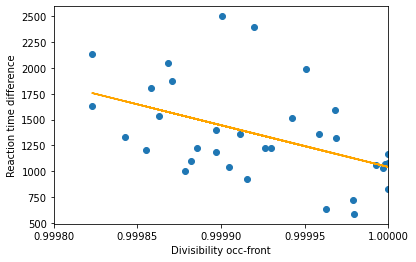

In [49]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

z = np.polyfit(div_occ_front_diff, diff_reaction_time_stat, 1)
p = np.poly1d(z)
plt.plot(div_occ_front_diff, p(div_occ_front_diff), color = 'orange', linestyle="solid")
#plt.plot(div_occ_front_diff[0], p(div_occ_front_diff[0]), div_occ_front_diff[-1], p(div_occ_front_diff[-1]))

plt.scatter(div_occ_front_diff, diff_reaction_time_stat)
plt.locator_params(axis='x', nbins=4)
plt.xlabel("Divisibility occ-front")
plt.ylabel("Reaction time difference")
plt.xlim(left = 0.9998, right = 1)
plt.show()

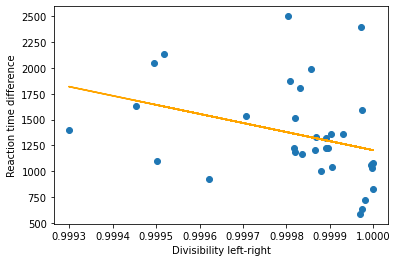

In [50]:
import matplotlib.pyplot as plt

z = np.polyfit(div_legt_right_diff, diff_reaction_time_stat, 1)
p = np.poly1d(z)
plt.plot(div_legt_right_diff, p(div_legt_right_diff), color = 'orange', linestyle="solid")

plt.scatter(div_legt_right_diff, diff_reaction_time_stat)
plt.xlabel("Divisibility left-right")
plt.ylabel("Reaction time difference")
plt.show()

### SN diff

In [52]:
diff_reaction_time_loc_sn = soc_reaction_times_loc - non_soc_reaction_times_loc
diff_reaction_time_stat_sn = soc_reaction_times_stat - non_soc_reaction_times_stat

In [53]:
#Intra
print("Pearsons correlation sn intra occ: " + str(pearsonr(diff_reaction_time_loc_sn, w_occ_diff_sn)))
print("Pearsons correlation sn intra front: " + str(pearsonr(diff_reaction_time_loc_sn, w_front_diff_sn)))
print("Pearsons correlation sn intra right: " + str(pearsonr(diff_reaction_time_loc_sn, w_right_diff_sn)))
print("Pearsons correlation sn intra left: " + str(pearsonr(diff_reaction_time_loc_sn, w_left_diff_sn)))

#Inter
print("Pearsons correlation social inter occ_front: " + str(pearsonr(diff_reaction_time_loc_sn, w_occ_front_diff_sn)))
print("Pearsons correlation social intra right_left: " + str(pearsonr(diff_reaction_time_loc_sn, w_legt_right_diff_sn)))

#Mod
print("Pearsons correlation sn mod occ_front: " + str(pearsonr(diff_reaction_time_loc_sn, mod_occ_front_diff_sn)))
print("Pearsons correlation sn mod right_left: " + str(pearsonr(diff_reaction_time_loc_sn, mod_left_right_diff_sn)))

#Div
print("Pearsons correlation sn div occ_front: " + str(pearsonr(diff_reaction_time_loc_sn, div_occ_front_diff_sn)))
print("Pearsons correlation sn div right_left: " + str(pearsonr(diff_reaction_time_loc_sn, div_legt_right_diff_sn)))

Pearsons correlation sn intra occ: (-0.18342559018754612, 0.29909176232910306)
Pearsons correlation sn intra front: (-0.18342559018754612, 0.29909176232910306)
Pearsons correlation sn intra right: (-0.18342559018754612, 0.29909176232910306)
Pearsons correlation sn intra left: (-0.18342559018754612, 0.29909176232910306)
Pearsons correlation social inter occ_front: (-0.05028248123356864, 0.7776317552324739)
Pearsons correlation social intra right_left: (-0.17618199174477905, 0.3189064995490697)
Pearsons correlation sn mod occ_front: (-0.05686551286364998, 0.7493957965823352)
Pearsons correlation sn mod right_left: (0.13068300411029676, 0.46132177357010706)
Pearsons correlation sn div occ_front: (0.05028387164989339, 0.7776257604195008)
Pearsons correlation sn div right_left: (0.17617975417461224, 0.318912743925759)


In [54]:
#Intra
print("Pearsons correlation sn intra occ: " + str(pearsonr(diff_reaction_time_stat_sn, w_occ_diff_sn)))
print("Pearsons correlation sn intra front: " + str(pearsonr(diff_reaction_time_stat_sn, w_front_diff_sn)))
print("Pearsons correlation sn intra right: " + str(pearsonr(diff_reaction_time_stat_sn, w_right_diff_sn)))
print("Pearsons correlation sn intra left: " + str(pearsonr(diff_reaction_time_stat_sn, w_left_diff_sn)))

#Inter
print("Pearsons correlation sn inter occ_front: " + str(pearsonr(diff_reaction_time_stat_sn, w_occ_front_diff_sn)))
print("Pearsons correlation sn intra right_left: " + str(pearsonr(diff_reaction_time_stat_sn, w_legt_right_diff_sn)))

#Mod
print("Pearsons correlation sn mod occ_front: " + str(pearsonr(diff_reaction_time_stat_sn, mod_occ_front_diff_sn)))
print("Pearsons correlation sn mod right_left: " + str(pearsonr(diff_reaction_time_stat_sn, mod_left_right_diff_sn)))

#Div
print("Pearsons correlation sn div occ_front: " + str(pearsonr(diff_reaction_time_stat_sn, div_occ_front_diff_sn)))
print("Pearsons correlation sn div right_left: " + str(pearsonr(diff_reaction_time_stat_sn, div_legt_right_diff_sn)))

Pearsons correlation sn intra occ: (0.10528243865020889, 0.5534587696924855)
Pearsons correlation sn intra front: (0.10528243865020886, 0.5534587696924855)
Pearsons correlation sn intra right: (0.10528243865020889, 0.5534587696924855)
Pearsons correlation sn intra left: (0.10528243865020884, 0.5534587696924864)
Pearsons correlation sn inter occ_front: (0.08681772172093227, 0.625395181289008)
Pearsons correlation sn intra right_left: (-0.15645144827753082, 0.37691362859445404)
Pearsons correlation sn mod occ_front: (-0.07831109957695569, 0.6597737507910245)
Pearsons correlation sn mod right_left: (0.09893585406350984, 0.5777455243247648)
Pearsons correlation sn div occ_front: (-0.08681221299051017, 0.6254172049811918)
Pearsons correlation sn div right_left: (0.15642325440011873, 0.3770006987389393)


### NS diff

In [55]:
diff_reaction_time_loc_ns = non_soc_reaction_times_loc - soc_reaction_times_loc
diff_reaction_time_stat_ns = non_soc_reaction_times_stat - soc_reaction_times_stat

In [56]:
#Intra
print("Pearsons correlation ns intra occ: " + str(pearsonr(diff_reaction_time_loc_ns, w_occ_diff_ns)))
print("Pearsons correlation ns intra front: " + str(pearsonr(diff_reaction_time_loc_ns, w_front_diff_ns)))
print("Pearsons correlation ns intra right: " + str(pearsonr(diff_reaction_time_loc_ns, w_right_diff_ns)))
print("Pearsons correlation ns intra left: " + str(pearsonr(diff_reaction_time_loc_ns, w_left_diff_ns)))

#Inter
print("Pearsons correlation ns inter occ_front: " + str(pearsonr(diff_reaction_time_loc_ns, w_occ_front_diff_ns)))
print("Pearsons correlation ns intra right_left: " + str(pearsonr(diff_reaction_time_loc_ns, w_legt_right_diff_ns)))

#Mod
print("Pearsons correlation ns mod occ_front: " + str(pearsonr(diff_reaction_time_loc_ns, mod_occ_front_diff_ns)))
print("Pearsons correlation ns mod right_left: " + str(pearsonr(diff_reaction_time_loc_ns, mod_left_right_diff_ns)))

#Div
print("Pearsons correlation ns div occ_front: " + str(pearsonr(diff_reaction_time_loc_ns, div_occ_front_diff_ns)))
print("Pearsons correlation ns div right_left: " + str(pearsonr(diff_reaction_time_loc_ns, div_legt_right_diff_ns)))

Pearsons correlation ns intra occ: (0.08439705266834703, 0.6351033660532696)
Pearsons correlation ns intra front: (0.084397052668347, 0.6351033660532713)
Pearsons correlation ns intra right: (0.08439705266834695, 0.6351033660532713)
Pearsons correlation ns intra left: (0.08439705266834695, 0.6351033660532713)
Pearsons correlation ns inter occ_front: (0.02802663831829169, 0.8749768929462365)
Pearsons correlation ns intra right_left: (0.21519827105719402, 0.22161007816231304)
Pearsons correlation ns mod occ_front: (0.010176903881012465, 0.9544473663650422)
Pearsons correlation ns mod right_left: (-0.011497287133479738, 0.9485445859854895)
Pearsons correlation ns div occ_front: (-0.028005085798842755, 0.8750722835555823)
Pearsons correlation ns div right_left: (-0.21519620504533812, 0.22161462139451998)


In [57]:
#Intra
print("Pearsons correlation ns intra occ: " + str(pearsonr(diff_reaction_time_stat_ns, w_occ_diff_ns)))
print("Pearsons correlation ns intra front: " + str(pearsonr(diff_reaction_time_stat_ns, w_front_diff_ns)))
print("Pearsons correlation ns intra right: " + str(pearsonr(diff_reaction_time_stat_ns, w_right_diff_ns)))
print("Pearsons correlation ns intra left: " + str(pearsonr(diff_reaction_time_stat_ns, w_left_diff_ns)))

#Inter
print("Pearsons correlation ns inter occ_front: " + str(pearsonr(diff_reaction_time_stat_ns, w_occ_front_diff_ns)))
print("Pearsons correlation ns intra right_left: " + str(pearsonr(diff_reaction_time_stat_ns, w_legt_right_diff_ns)))

#Mod
print("Pearsons correlation ns mod occ_front: " + str(pearsonr(diff_reaction_time_stat_ns, mod_occ_front_diff_ns)))
print("Pearsons correlation ns mod right_left: " + str(pearsonr(diff_reaction_time_stat_ns, mod_left_right_diff_ns)))

#Div
print("Pearsons correlation ns div occ_front: " + str(pearsonr(diff_reaction_time_stat_ns, div_occ_front_diff_ns)))
print("Pearsons correlation ns div right_left: " + str(pearsonr(diff_reaction_time_stat_ns, div_legt_right_diff_ns)))

Pearsons correlation ns intra occ: (0.08504616517268405, 0.6324941203065995)
Pearsons correlation ns intra front: (0.08504616517268404, 0.6324941203065995)
Pearsons correlation ns intra right: (0.08504616517268399, 0.6324941203065985)
Pearsons correlation ns intra left: (0.08504616517268399, 0.6324941203065985)
Pearsons correlation ns inter occ_front: (0.24667611142679138, 0.159605988582279)
Pearsons correlation ns intra right_left: (0.1419654766214251, 0.4231898327868826)
Pearsons correlation ns mod occ_front: (0.198695176373273, 0.259944068733686)
Pearsons correlation ns mod right_left: (-0.21076937866554143, 0.2314956434628246)
Pearsons correlation ns div occ_front: (-0.246677307618774, 0.15960389951621062)
Pearsons correlation ns div right_left: (-0.14193749298318714, 0.4232821790485355)


## Accs

In [ ]:
with open('/content/drive/MyDrive/soc_acc_loc.pkl', 'rb') as f:
  soc_acc_loc = pickle.load(f)
  
with open('/content/drive/MyDrive/non_soc_acc_loc.pkl', 'rb') as f:
  non_soc_acc_loc = pickle.load(f)

with open('/content/drive/MyDrive/soc_acc_stat.pkl', 'rb') as f:
  soc_acc_stat = pickle.load(f)

with open('/content/drive/MyDrive/non_soc_acc_stat.pkl', 'rb') as f:
  non_soc_acc_stat = pickle.load(f)

In [ ]:
soc_acc_loc = soc_acc_loc[valid_subs]
non_soc_acc_loc= non_soc_acc_loc[valid_subs]
soc_acc_stat= soc_acc_stat[valid_subs]
non_soc_acc_stat= non_soc_acc_stat[valid_subs]

In [ ]:
diff_acc_loc = np.abs(soc_acc_loc - non_soc_acc_loc)
diff_acc_stat = np.abs(soc_acc_stat - non_soc_acc_stat)

In [ ]:
#Intra
print("Pearsons correlation social intra occ: " + str(pearsonr(diff_acc_loc, w_occ_diff)))
print("Pearsons correlation social intra front: " + str(pearsonr(diff_acc_loc, w_front_diff)))
print("Pearsons correlation social intra right: " + str(pearsonr(diff_acc_loc, w_right_diff)))
print("Pearsons correlation social intra left: " + str(pearsonr(diff_acc_loc, w_left_diff)))

#Inter
print("Pearsons correlation social inter occ_front: " + str(pearsonr(diff_acc_loc, w_occ_front_diff)))
print("Pearsons correlation social intra right_left: " + str(pearsonr(diff_acc_loc, w_legt_right_diff)))

#Mod
print("Pearsons correlation social mod occ_front: " + str(pearsonr(diff_acc_loc, mod_occ_front_diff)))
print("Pearsons correlation social mod right_left: " + str(pearsonr(diff_acc_loc, mod_left_right_diff)))

#Div
print("Pearsons correlation social div occ_front: " + str(pearsonr(diff_acc_loc, div_occ_front_diff)))
print("Pearsons correlation social div right_left: " + str(pearsonr(diff_acc_loc, div_legt_right_diff)))

Pearsons correlation social intra occ: (0.11680956804519833, 0.5106072460841575)
Pearsons correlation social intra front: (0.11680956804519835, 0.5106072460841575)
Pearsons correlation social intra right: (0.11680956804519832, 0.5106072460841575)
Pearsons correlation social intra left: (0.11680956804519833, 0.5106072460841575)
Pearsons correlation social inter occ_front: (0.10151603962677, 0.5678143358440421)
Pearsons correlation social intra right_left: (-0.03289087521274699, 0.853494710130542)
Pearsons correlation social mod occ_front: (-0.0024388169779189887, 0.9890783319923079)
Pearsons correlation social mod right_left: (0.024501401608500405, 0.8906015017502402)
Pearsons correlation social div occ_front: (-0.15056283267268258, 0.3953545842952968)
Pearsons correlation social div right_left: (-0.011109246502581275, 0.9502790585593728)


In [ ]:
#Intra
print("Pearsons correlation social intra occ: " + str(pearsonr(diff_acc_stat, w_occ_diff)))
print("Pearsons correlation social intra front: " + str(pearsonr(diff_acc_stat, w_front_diff)))
print("Pearsons correlation social intra right: " + str(pearsonr(diff_acc_stat, w_right_diff)))
print("Pearsons correlation social intra left: " + str(pearsonr(diff_acc_stat, w_left_diff)))

#Inter
print("Pearsons correlation social inter occ_front: " + str(pearsonr(diff_acc_stat, w_occ_front_diff)))
print("Pearsons correlation social intra right_left: " + str(pearsonr(diff_acc_stat, w_legt_right_diff)))

#Mod
print("Pearsons correlation social mod occ_front: " + str(pearsonr(diff_acc_stat, mod_occ_front_diff)))
print("Pearsons correlation social mod right_left: " + str(pearsonr(diff_acc_stat, mod_left_right_diff)))

#Div
print("Pearsons correlation social div occ_front: " + str(pearsonr(diff_acc_stat, div_occ_front_diff)))
print("Pearsons correlation social div right_left: " + str(pearsonr(diff_acc_stat, div_legt_right_diff)))

Pearsons correlation social intra occ: (-0.14149123931683566, 0.42475633714836475)
Pearsons correlation social intra front: (-0.14149123931683558, 0.4247563371483645)
Pearsons correlation social intra right: (-0.1414912393168356, 0.4247563371483645)
Pearsons correlation social intra left: (-0.14149123931683555, 0.42475633714836514)
Pearsons correlation social inter occ_front: (-0.060688706789354514, 0.7331404147636923)
Pearsons correlation social intra right_left: (-0.02953466926082511, 0.8683067763607402)
Pearsons correlation social mod occ_front: (-0.12196270534984585, 0.4920006332984418)
Pearsons correlation social mod right_left: (-0.09631067000348233, 0.587929036387904)
Pearsons correlation social div occ_front: (0.1451604425486566, 0.4127204901597723)
Pearsons correlation social div right_left: (0.09171800372792038, 0.6059319988538797)
